# Code for generating surrogate models of deterministic simulations
### Stuart Mead, Jonathan Procter and Mark Bebbington

This code, and sample data can be used to generate the probabilistic surrogates for the accompanying paper 'Probabilistic volcanic mass flow hazard assessment using statistical surrogates of deterministic simulations'

### Imports and installs

If using google colaboratory - you will need to install the GPy package. The command pip install GPy can also be run in your python environment to install the package.

In [ ]:
#Install GPy
!pip install GPy

     |████████████████████████████████| 959 kB 4.9 MB/s 
     |████████████████████████████████| 71 kB 10.5 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565066 sha256=9676646b9df112a06c5816a050da5287a6d86d266f8be0278a75c3087e0c586f
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=ad828ebf226ed792b08e09fe9626908f0cbe46a947fdf8cc1cf725d3cf43eb75
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


The program also relies on the Numpy (for array reading and processing), Pandas (data managment), and Scipy packages (for minimisation)

In [1]:
#Imports   
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize, minimize_scalar
from IPython.core.display import display
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
from matplotlib import pyplot as plt

#### Create robust prior class
The followign code creates the 'Approximate Robust Prior' from Gu (2019). The definition of the prior is from the GPy documentation, this class stores the key parameters of Cl, a, and b.

In [2]:
#Create Approximate Robust Prior (from Gu 2019) class
from paramz.domains import _REAL, _POSITIVE, _NEGATIVE
import weakref

class ApproxRef(GPy.core.parameterization.priors.Prior):
    """
    Implementation of the approx reference prior from Mengyang Gu (2019)
    """
    #A lot of the base class defintions are copied from GPy.Gamma class
    domain = _POSITIVE
    _instances = []
    
    ##Create
    def __new__(cls, Cl, b, a=0.2):  # Singleton:
        if cls._instances:
            cls._instances[:] = [instance for instance in cls._instances if instance()]
            for instance in cls._instances:
                if instance().Cl == Cl and instance().b == b and instance().a == a:
                    return instance()
        newfunc = super(GPy.core.parameterization.priors.Prior, cls).__new__
        if newfunc is object.__new__:
            o = newfunc(cls)  
        else:
            o = newfunc(cls, Cl, b, a)            
        cls._instances.append(weakref.ref(o))
        return cls._instances[-1]()
    
    #Properties - Cl, a, b (Table 4.1 of Gu 2019)
    @property
    def Cl(self):
        return self._Cl
    
    @property
    def a(self):
        return self._a
    
    @property
    def b(self):
        return self._b
    
    def __init__(self, Cl, b, a):
        self._Cl = float(Cl)
        self._a = float(a)
        self._b = float(b)
    
    #String return
    def __str__(self):
        return "JR(CL:" + str(self.Cl) + ", {:.2g}, {:.4g})".format(self.a, self.b)
    
    #Summary return (NA)
    def summary(self):
        ret = {"Inverse range": 1. / self.b}
        return ret
    
    #The lognormal of the PDF - see Equation 4.1 of Gu thesis, where x is the lengthscale
    def lnpdf(self, x):
        beta = 1./x
        #Calculate T (the Cl.Bl part)
        t = np.multiply(self.Cl, beta)
        #Calculate 4.1a
        partI = -self.b*t
        partII = self.a*np.log(t)
        return partI + partII
    
    #Calculate the gradient of the pdf, where x is the lengthscale
    def lnpdf_grad(self, x):
        #Beta is 1/lengthscale
        beta = 1./x
        #Calc t
        t = np.multiply(self.Cl, beta)
        #Return
        return (self.a*self.Cl/t - self.b*self.Cl)
    
    # Randomvalues are requried to fully define the prior, but should not be used.
    ## Better to take mixture from betas calculated
    def rvs(self, n):
        return np.random.rand(n) 
    
    #Helper function to calculate C_l
    def calcCL(input_points, n_variables):
        return (np.max(input_points) - np.min(input_points))/math.pow(float(len(input_points)),1./float(n_variables))

### Functions to initialise priors and GP regression

These functions are used to calculate parameters and initial values from the data, again following the general methodology of Gu (2019).

In [3]:
#Calculate R0 matrix - the distance between each element in the input design space
def determineRO(input_matrix):
    #Initialise
    return np.abs(np.subtract.outer(input_matrix, input_matrix))

#Lower bound function - provide a guess for the initial lower bound of lengthscale
def LB_func(guess, inputs, kernel):
    #Inputs is a list of arrays from RO
    #Hardcode tolerance
    tol =1.e16
    n_inputs = float(len(inputs[0]))
    proposal = np.exp(guess)/(np.exp(guess) + 1.)
    LB = np.log(-np.log(proposal)/[np.max(inputs[i]) for i in range(np.shape(inputs)[0])])
    R = np.ones(np.shape(inputs[0]))
    for it, nb in enumerate(kernel.parts):
        nb.lengthscale = 1./np.exp(LB[it])
        R = np.multiply(np.matrix(nb.K(inputs[it])), R)
    return math.pow(np.linalg.cond(R)-tol, 2)

#Calculate parameter Cl, Eqn 4.1 in Gu thesis, required to define prior
def calcCL(input_points, n_variables):
    return (np.max(input_points) - np.min(input_points))/math.pow(float(len(input_points)),1./float(n_variables))

#Step 4: Calculate the (log) marginal likelihood posterior for the robust prior, and its derivative for optimisation
# functions
def calcB(input_points, n_variables, a = 0.2):
    return 1./math.pow(float(len(input_points)),1./float(n_variables)) * (a + n_variables)

## GP emulation
The following code is specific to the data, it reads in the simulation dataset (as a table) and initialises the Gaussian Process model.

In [4]:
#Load in the dataset, which is the extract of PDC flow heights from each simulation,
## and its associated values of N,E, orientation, volume and friction.
data = pd.read_pickle(r'taranaki_LIDAR-PDC_stony.pk')
#Convert orientation from degrees to radians
data[['orientation']] = np.deg2rad(data[['orientation']])
data.describe()

,height,run,utmx,utmy,vol,orientation,friction,lhsx,lhsy,lhsvol,lhsor,maxDp,maxKe
count,1024.000000,1024.00000,1024.000000,1.024000e+03,1.024000e+03,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1023.000000,1023.000000
mean,1.807829,511.50000,246739.758280,5.646244e+06,5.050000e+06,1.570796,13.456592,0.500000,0.500000,0.500000,0.500000,0.820093,172.407809
std,2.744723,295.74764,104.978292,1.051162e+02,2.859279e+06,0.907342,4.568905,0.288816,0.288816,0.288816,0.288816,2.226551,472.154747
min,0.000000,0.00000,246531.920713,5.646035e+06,1.048340e+05,0.001534,9.487826,0.000488,0.000488,0.000488,0.000488,0.000000,0.000000
25%,0.000000,255.75000,246655.725821,5.646159e+06,2.577417e+06,0.786165,10.410851,0.250244,0.250244,0.250244,0.250244,0.000000,0.000000
50%,0.000000,511.50000,246740.003122,5.646245e+06,5.050000e+06,1.570796,11.850573,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000
75%,3.073036,767.25000,246824.517474,5.646326e+06,7.522583e+06,2.355427,14.711930,0.749756,0.749756,0.749756,0.749756,0.061205,12.319097
max,13.083786,1023.00000,246948.430520,5.646455e+06,9.995166e+06,3.140059,37.361273,0.999512,0.999512,0.999512,0.999512,15.260366,3275.516202


In [5]:
#Initialise Kernels for lengthscale estimation.
## These are Matern32's for location and volume, and periodic Matern52's for oreintation
#UTM x and y
cUtm = GPy.kern.Matern32(input_dim=2, variance = 1.0, active_dims=[0,1], lengthscale= 1.0)
#Volume
cVol = GPy.kern.Matern32(input_dim = 1, variance=0.1, active_dims=[2], lengthscale=1.0)
#Orientation
cOr = GPy.kern.PeriodicMatern52(input_dim=1, variance=0.1, lengthscale=1.0, period=np.pi, n_freq=1, active_dims=[3]) 
#Combine each of these dimensions
c = cVol * cUtm * cOr

In [6]:
#Now define the parameters needed for priors.
#Calculate Cl - a scaling parameter - Mean of absolute distance. See Gu (2019)
inputs = data[['utmx','utmy','vol', 'orientation']].values
cl = [calcCL(inputs[:,i], 4) for i in range(np.shape(inputs)[1])]
cl

[73.62922724009913, 74.10071243016743, 1748380.2118699648, 0.5548180231611338]

In [7]:
#Find the lower bound of the prior - See Gu (2019)
## First find the distance between each input element (R0 matrix)
R_zero = [determineRO(inputs[:,i]) for i in range(np.shape(inputs)[1])]
## Minimise the lower bound function
LBa = [minimize_scalar(LB_func, bounds=(-5.,12.), method='bounded', 
                      args=(R_zero, 
                            c)).x]
## Get the initial prob
LBp = np.exp(LBa)/(np.exp(LBa)+1)
## Find the lower bound
LB = np.log(-np.log(LBp)/[np.max(determineRO(inputs[:,i])) for i in range(np.shape(inputs)[1])])

In [8]:
#Step 3: Set upper bound and initial value for lengthscale (beta is 1/x)
initialBeta = 50.*np.exp(LB)
logInitialBeta = np.log(initialBeta)
upperBound = 1/np.exp(LB)
print("Upper bounds: " + str(upperBound)+"\n")
print("Initial values: " + str(1/initialBeta) +"\n")
print("Lower bounds: " + str(LB))

Upper bounds: [1.51306769e+04 1.52275663e+04 3.59289064e+08 1.14014130e+02]

Initial values: [3.02613539e+02 3.04551326e+02 7.18578128e+06 2.28028259e+00]

Lower bounds: [ -9.62447955  -9.63086264 -19.69963782  -4.73632239]


In [9]:
#Create kernel for optimisation, using the initial bounds to define lengthscale
cUtm = GPy.kern.Matern32(input_dim=2, variance = 1.0, active_dims=[0,1], 
                         ARD=True, lengthscale= [1./initialBeta[0], 1./initialBeta[1]])

cOr = GPy.kern.PeriodicMatern52(input_dim=1, variance = 1.0, lengthscale= 1./initialBeta[3],
                                    period=np.pi, n_freq = 1, active_dims=[3]) + GPy.kern.Bias(input_dim=1, 
                                                                                               variance=1, active_dims=[3])
cVol = GPy.kern.Matern32(input_dim=1, variance=1.0, 
                         active_dims=[2], lengthscale=1./initialBeta[2])
c = cVol * cUtm  * cOr

 /home/smead/envs/emulators/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [10]:
#Calculate b
b = calcB(inputs, 4)

## Warped GP definition and fitting
The following code defines the Warped Gaussian Process model for fitting

In [11]:
#Create warping function, which is a hyperbolic tan, with 1 step change
warping_fn = GPy.util.warping_functions.TanhFunction(n_terms=1)
warping_fn

warp_tanh.,value,constraints,priors
psi,"(1, 3)",{+ve},
d,1.0,+ve,


In [12]:
#Create warped Gaussian process model, using the kernel defined previously, data, and warping function
w = GPy.models.WarpedGP(X = data[['utmx','utmy','vol', 'orientation']].values, 
                        Y = data[['height']].values, #Without warping, log1p can be used, see Snelson (2001)
                        kernel = c,
                        warping_function = warping_fn)
w

gp.,value,constraints,priors
mul.Mat32.variance,1.0,+ve,
mul.Mat32.lengthscale,7185781.283271957,+ve,
mul.Mat32_1.variance,1.0,+ve,
mul.Mat32_1.lengthscale,"(2,)",+ve,
mul.sum.periodic_Matern52.variance,1.0,+ve,
mul.sum.periodic_Matern52.lengthscale,2.280282594933499,+ve,
mul.sum.periodic_Matern52.period,3.141592653589793,+ve,
mul.sum.bias.variance,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,
warp_tanh.psi,"(1, 3)",{+ve},


In [13]:
#Set Priors for the model
a = 0.2
#UTM x and Y - uses the reference prior of Gu.
w.kern.Mat32_1.lengthscale.set_prior(ApproxRef(cl[0], b, a))
w.kern.Mat32_1.variance.constrain_fixed(1.0)
#Orientation - as above, but fixes the period to pi.
w.kern.sum.periodic_Matern52.lengthscale.set_prior(ApproxRef(cl[3], b, a))
w.kern.sum.periodic_Matern52.period.constrain_fixed()
w.kern.sum.periodic_Matern52.variance.constrain_fixed(1.0)
w.kern.sum.bias.constrain_fixed(1.0)
#Volume - as above
w.kern.Mat32.lengthscale.set_prior(ApproxRef(cl[2], b, a))
w.kern.Mat32.variance.constrain_fixed(1.0)
#Print the Kernel
w

reconstraining parameters gp.mul.Mat32_1.lengthscale
reconstraining parameters gp.mul.sum.periodic_Matern52.lengthscale
reconstraining parameters gp.mul.Mat32.lengthscale
 /home/smead/envs/emulators/lib/python3.8/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1


gp.,value,constraints,priors
mul.Mat32.variance,1.0,+ve fixed,
mul.Mat32.lengthscale,7185781.283271957,+ve,"JR(CL:1748380.2118699648, 0.2, 0.7425)"
mul.Mat32_1.variance,1.0,+ve fixed,
mul.Mat32_1.lengthscale,"(2,)",+ve,"JR(CL:73.62922724009913, 0.2, 0.7425)"
mul.sum.periodic_Matern52.variance,1.0,+ve fixed,
mul.sum.periodic_Matern52.lengthscale,2.280282594933499,+ve,"JR(CL:0.5548180231611338, 0.2, 0.7425)"
mul.sum.periodic_Matern52.period,3.141592653589793,+ve fixed,
mul.sum.bias.variance,1.0,+ve fixed,
Gaussian_noise.variance,1.0,+ve,
warp_tanh.psi,"(1, 3)",{+ve},


In [14]:
#Optimise using SCG. Note lbfgs, or simplex can also be used 
w.optimize('scg', messages = True)

Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    00s00  0000   9.741311e+02           nan 

 /home/smead/envs/emulators/lib/python3.8/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1



    05s45  0015   4.964404e+02   1.937477e+10 
    12s32  0033   4.882028e+02   1.937540e+10 

 /home/smead/envs/emulators/lib/python3.8/site-packages/GPy/util/warping_functions.py:142: RuntimeWarning:overflow encountered in cosh
 /home/smead/envs/emulators/lib/python3.8/site-packages/GPy/util/warping_functions.py:143: RuntimeWarning:overflow encountered in cosh
 /home/smead/envs/emulators/lib/python3.8/site-packages/GPy/util/warping_functions.py:144: RuntimeWarning:overflow encountered in cosh
 /home/smead/envs/emulators/lib/python3.8/site-packages/GPy/util/warping_functions.py:152: RuntimeWarning:overflow encountered in cosh
 /home/smead/envs/emulators/lib/python3.8/site-packages/GPy/util/warping_functions.py:153: RuntimeWarning:overflow encountered in cosh


    14s52  0039   1.583121e+02   1.937540e+10 
    16s83  0045   4.719846e+00   1.941351e+10 
    24s87  0066   2.936532e+06   1.941588e+10 

 /home/smead/envs/emulators/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning:overflow encountered in reduce


    50s72  0132   4.064990e+03   1.946756e+10 
 01m53s12  0299  -8.304877e+02   1.949150e+10 
Runtime:  01m53s12
Optimization status: converged - relative reduction in objective



[Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 5.0, '5.0'),
 Text(0, 10.0, '10.0')]

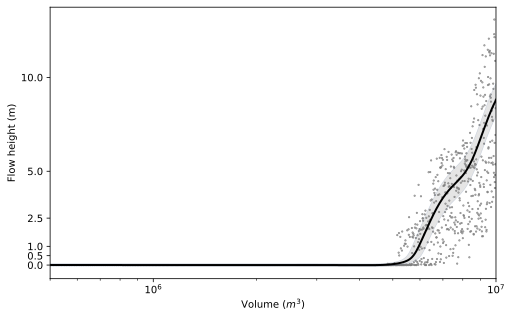

In [15]:
#Once optimisation completes, we can generate some plots
#Plot the emulator slice - this is Figure 5b in the manuscript
fig, axes = plt.subplots(1,1)
w.plot_data(ax = axes, visible_dims = [2], marker = '.', color = 'grey', s = 2)
w.plot_confidence(ax = axes, fixed_inputs = [(0,246740.), (1,5646305.), (3, 2.04)], plot_limits=[5.e5, 1.e7], plot_raw = False, label = None, color = 'grey')
w.plot_mean(ax = axes, fixed_inputs = [(0,246740.), (1,5646305.), (3, 2.04)], plot_limits=[5.e5, 1.e7], color = 'k', label = 'Mean')
axes.set_xlabel(r'Volume ($m^{3}$)')
axes.set_xticks([1.e5, 5.e5, 1.e6, 2.5e6, 5.e6, 1.e7])
axes.set_xticklabels([r'1.0 $\times 10^{5}$',
                        r'5.0 $\times 10^{5}$',
                        r'1.0 $\times 10^{6}$',
                        r'2.5 $\times 10^{6}$',
                        r'5.0 $\times 10^{6}$',
                        #r'7.5 $\times 10^{6}$',
                        r'1.0 $\times 10^{7}$',
                       ]
  )
axes.set_xlim([5e5, 1.e7])
axes.set_xscale('log')
axes.set_ylabel('Flow height (m)')
axes.set_yticks([0.,0.5,1.0,2.5, 5., 10.0])
axes.set_yticklabels(['0.0','0.5','1.0','2.5','5.0', '10.0'])

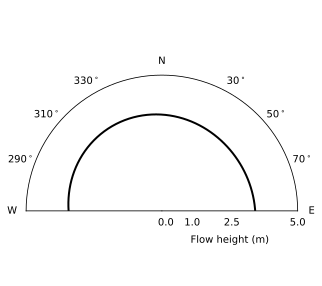

In [17]:
#Plot slice of emulator with orientation - this is Figure 6 of the manuscript
ventLocation = [(0,246740.), (1,5646305.)] #N,E location of vent 

fig, axes = plt.subplots(1,1, subplot_kw=dict(projection='polar'))
w.plot_mean(ax=axes,fixed_inputs = [ventLocation[0], ventLocation[1], (2, 7.e6)], color = 'k', linestyle = '-')
axes.set_ylim([-0.15,5.0])
axes.yaxis.set_label_coords(0.75, 0.125)
axes.set_ylabel('Flow height (m)', rotation = 0)
axes.set_yticks([0.,1.0,2.5, 5.])
axes.set_yticklabels(['0.0','1.0','2.5','5.0'])
axes.set_thetagrids((0, 20, 40, 60, 90, 120, 140, 160, 180), labels = ('E', '70$^\circ$', '50$^\circ$', '30$^\circ$', 'N', '330$^\circ$', '310$^\circ$', '290$^\circ$', 'W'))
axes.grid(linewidth = 0.5)
axes.set_thetamin(0)
axes.set_thetamax(180)

### LOO assesment
In this section, we perform the Leave-One Out assessment using the approximations of Vehtari et al. (2016)

In [18]:
#The mean and variance is estimates using the inverse of the posterior - Equations 32 and 33. 
# These functions calculate those

#Calculate the mean - this provides an array of the mean estimate for each simulated point
def calcLooMu(emulator):
  g = emulator.posterior.woodbury_vector
  cdiag = np.diag(emulator.posterior.woodbury_inv)[:, None]
  mu = emulator.Y - g/cdiag
  return mu

#Calculate the variance - as above, but for variance
def calcLooVar(emulator):
  var = 1/np.diag(emulator.posterior.woodbury_inv)[:, None]
  return var

In [19]:
#Use the functions to calculate the mean and variance
u = calcLooMu(w)
var = calcLooVar(w)
loo = np.c_[u, var, w.Y]

In [20]:
#Write some helper functions to sort the data by height, and identify elements that are within the mean+2SD value
looSorted = loo[loo[:,0].argsort()]
withinConfidence = np.logical_and(looSorted[:,0]-2.0*np.sqrt(looSorted[:,1])>looSorted[:,2],
                                  looSorted[:,0]+2.0*np.sqrt(looSorted[:,1])>looSorted[:,2])

Text(0, 0.5, 'Emulated height (m)')

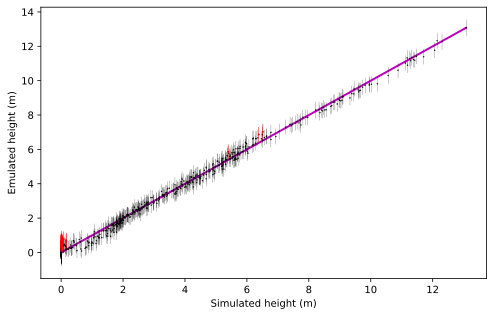

In [21]:
#Plotting - this is Figure 4b in the manuscript
fig, axes = plt.subplots(1,1)
axes.errorbar(looSorted[withinConfidence,2], looSorted[withinConfidence,0], yerr = 2.0*np.sqrt(looSorted[withinConfidence, 1]), fmt='.', markersize = 2.0, c = 'r', elinewidth = 0.5, zorder = 7)
axes.errorbar(looSorted[~withinConfidence,2], looSorted[~withinConfidence,0], yerr = 2.0*np.sqrt(looSorted[~withinConfidence, 1]), fmt='.', c = 'k', markersize = 1.0, elinewidth = 0.2)
axes.plot(w.Y, w.Y, color= 'm', linewidth = 2, zorder = 0)
axes.set_xlabel('Simulated height (m)')
axes.set_ylabel('Emulated height (m)')

## Hazard assessment
This section is not run in the current notebook - it takes approximately 7 minutes, so be careful with running!
It is a relatively straightforward hazard assessment - fit a PDF to the volume distribution using a powerlaw function, then sample the data using the PDF, and plot an empirical CDF from this data.

In [ ]:
#Install powerlaw package
!pip install powerlaw

In [23]:
import powerlaw
import statsmodels.distributions.empirical_distribution as smd

In [24]:
#Read Hartnett et al. dome collapse data
DomeData = pd.read_csv('DomeData.csv', names = ("ID",
                                       "Location",
                                       "Date",
                                       "Comp",
                                       "DepVol",
                                       "Vol",
                                       "proportion"),
                       dtype = {"ID":np.int32,
                                "DepVol":np.float32,
                                "Vol":np.float32,
                                "proportion":np.float32},
                       header = 0)
DomeData = DomeData.drop([225])
DomeData = DomeData[DomeData.Comp == 'A']

Calculating best minimal value for power law fit
 /home/smead/envs/emulators/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning:invalid value encountered in true_divide


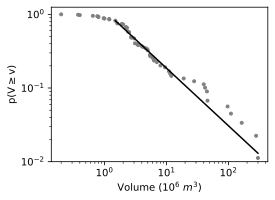

In [25]:
#Fit and plot the data to the Andesitic domes in the GLADIS dataset. This is Figure 7 in the manuscript.
fit = powerlaw.Fit(DomeData['DepVol'].dropna())
fig, axes = plt.subplots(1,1, figsize = (4,3))

axes.scatter(fit.ccdf(original_data=True)[0], fit.ccdf(original_data=True)[1], marker = '.', color = 'grey', zorder = 1)
axes.set_xscale('log')
axes.set_yscale('log')
#fit.power_law.plot_ccdf(color='k', ax=axes, zorder = 1)

x_pl = np.linspace(fit.xmin, np.max(fit.data), len(fit.data))
#add the scaling paramer
axes.plot(x_pl, fit.power_law.ccdf(x_pl) * 0.8202247, color = 'k')

#axes.set_xlim(fit.xmin)
axes.set_ylim(bottom = 10**-2)
        
axes.set_ylabel('p(V$\geq$v)')
axes.set_xlabel(r'Volume ($10^6$ $m^{3}$)')
fig.tight_layout()

### Monte-Carlo sampling
This uses a few helper functions, defining the polar location so we can do a uniform sample of our data by azimuth and radius from the centre, not a random distribution within a box.

In [26]:
def polarLocation(polar, radius):
    return np.array([np.sqrt(polar[:,0])*radius, polar[:,1]*(2.*np.pi)], order = 'F')
def getUTMXY(polar, vent):
    utmx = vent[0]+(polar[0]*np.cos(polar[1]))
    utmy = vent[1]+(polar[0]*np.sin(polar[1]))
    return utmx, utmy

In [55]:
#Create 10,000 draws of input conditions in U(UTM x/y, orientation) and power-law(volume)
nsamples = 10000
ventLocation = [246740.,5646305.]

input_sample_clip = np.zeros((nsamples, 4))

input_sample_clip[:, 0], input_sample_clip[:, 1]  = getUTMXY((np.sqrt(np.random.uniform(0,1,nsamples)*maxVentRadius),np.random.uniform(0,1,nsamples)*(2*np.pi)), ventLocation)
input_sample_clip[:, 2] = np.minimum(fit.power_law.generate_random(nsamples), 10.) * 10**6
input_sample_clip[:, 3] = np.random.uniform(0, np.pi, nsamples)

In [56]:
#Sample the posteior of the emulator (10 draws)
ndraws = 10
posterior_predict = np.zeros((nsamples, 1, ndraws))
posterior_predict = w.posterior_samples(input_sample_clip, size=ndraws)

 /usr/local/lib/python3.7/dist-packages/GPy/core/gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.


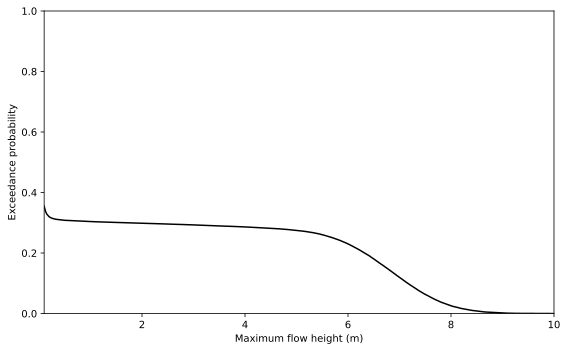

In [58]:
#Plot the ecdf - Not run
fig, axes = plt.subplots(1,1)
#Take the ECDF function of the posterior prediction, needs to be of the warping function.
ecdf_mean = smd.ECDF(w.warping_function.f_inv(posterior_predict).flatten())
axes.plot(ecdf_mean.x, 1-ecdf_mean.y, color = 'k')
axes.set_ylim(0,1.0)
axes.set_xlim(0.1, 10.0)
axes.set_ylabel('Exceedance probability')
axes.set_xlabel('Maximum flow height (m)')
fig.tight_layout()